# Self-RAG + LangGraph 例子

In [24]:
! pip install -U langgraph langchain-openai tavily-python langchain-community tiktoken langchainhub chromadb langchain langgraph



[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [25]:
import os
from dotenv import load_dotenv

# 初始化 langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "default"

# https://smith.langchain.com

# Tavily API Key
os.environ["TAVILY_API_KEY"] = "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"

# https://app.tavily.com/

# 加载 .env 文件
load_dotenv()

True

In [26]:
from langchain import hub as langchain_hub
from langchain.schema import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_openai import OpenAIEmbeddings
import os
from langchain_community.vectorstores.chroma import Chroma
from langchain_core.prompts import PromptTemplate
from string import Template
import uuid

# 读取 ./data/data.md 文件作为知识库
file_path = os.path.join('/Users/chenchen/Desktop/egg/aiops/module_5/demo_7/data', 'data.md')
with open(file_path, 'r', encoding='utf-8') as f:
    docs_string = f.read()

# split the document into chunks base on markdown headers
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
splits = text_splitter.split_text(docs_string)
print("Length of splits: ", len(splits))
print(splits)

# 向量化
# 保存到随机目录里
random_directory = "./" + str(uuid.uuid4())
# embedding = OpenAIEmbeddings(model="text-embedding-3-small",
#                              openai_api_key=os.getenv("OPENAI_API_KEY"), openai_api_base=os.getenv("OPENAI_API_BASE"))

embedding = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(documents=splits, embedding=embedding, persist_directory=random_directory)
vectorstore.persist()
retriever = vectorstore.as_retriever()

Length of splits:  11
[Document(metadata={'Header 1': '支付系统运维知识库', 'Header 2': '1. 系统监控指标'}, page_content='- **交易量**: 监控每秒交易数，确保系统承载能力。\n- **响应时间**: 监控交易的平均响应时间，确保服务性能。\n- **系统负载**: 监控CPU、内存等资源使用率，避免资源瓶颈。'), Document(metadata={'Header 1': '支付系统运维知识库', 'Header 2': '2. 常见问题与解决方案', 'Header 3': '2.1 交易失败'}, page_content='- **问题描述**: 用户发起支付后，交易未能成功完成。\n- **可能原因**:\n- 网络延迟或中断\n- 支付网关服务异常\n- **解决办法**:\n- 检查网络连接，确保支付服务的网络畅通。\n- 检查支付网关服务状态，重启服务或联系服务提供商。'), Document(metadata={'Header 1': '支付系统运维知识库', 'Header 2': '2. 常见问题与解决方案', 'Header 3': '2.2 响应时间过长'}, page_content='- **问题描述**: 用户支付请求处理时间超过正常范围。\n- **可能原因**:\n- 系统资源不足\n- 数据库查询效率低下\n- 外部服务响应慢\n- **解决办法**:\n- 增加系统资源，如CPU、内存。\n- 优化数据库查询，使用索引，减少复杂查询。\n- 与外部服务提供商沟通，优化接口性能。'), Document(metadata={'Header 1': '支付系统运维知识库', 'Header 2': '2. 常见问题与解决方案', 'Header 3': '2.3 系统宕机'}, page_content='- **问题描述**: 支付系统完全无法访问或服务中断。\n- **可能原因**:\n- 主机硬件故障\n- 系统软件崩溃\n- 网络设备故障\n- **解决办法**:\n- 快速切换到备用服务器。\n- 检查系统日志，定位问题原因。\n- 联系硬件供应商，进行故障排查和修复。'), Document(metadata={'Hea

In [27]:
# 评估检索的文档与用户提出的问题是否相关
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                 openai_api_base=os.getenv("OPENAI_API_BASE"))

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# prompt
system = """
您是一名评分员，负责评估检索到的文档与用户问题的相关性。\n
测试不需要很严格，目标是过滤掉错误的检索。\n
如果文档包含与用户问题相关的关键字或语义含义，则将其评为相关。\n
给出二进制分数"yes"或"no"，以指示文档是否与问题相关。
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: \n\n {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

# 相关问题
question = "payment_backend 服务是谁维护的"
# 不相关问题
# question = "北京天气如何"

docs = retriever._get_relevant_documents(question, run_manager=None)

# 观察每一个文档块的相关性判断结果
for doc in docs:
    print("doc: \n", doc.page_content, "\n")
    print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
    print("\n")

/Users/chenchen/Desktop/egg/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


doc: 
 微服务负责人:
- **payment_frontend**: 小张，联系方式：18888888888
- **payment_gateway**: 小王，联系方式：18888888889
- **payment_backend**: 小王，联系方式：18888888889
- **payment_callback**: 小李，联系方式：18888888890 
binary_score='yes'


doc: 
 - **问题描述**: 用户发起支付后，交易未能成功完成。
- **可能原因**:
- 网络延迟或中断
- 支付网关服务异常
- **解决办法**:
- 检查网络连接，确保支付服务的网络畅通。
- 检查支付网关服务状态，重启服务或联系服务提供商。 
binary_score='no'


doc: 
 - **问题描述**: 用户支付请求处理时间超过正常范围。
- **可能原因**:
- 系统资源不足
- 数据库查询效率低下
- 外部服务响应慢
- **解决办法**:
- 增加系统资源，如CPU、内存。
- 优化数据库查询，使用索引，减少复杂查询。
- 与外部服务提供商沟通，优化接口性能。 
binary_score='no'


doc: 
 - **问题描述**: 支付系统完全无法访问或服务中断。
- **可能原因**:
- 主机硬件故障
- 系统软件崩溃
- 网络设备故障
- **解决办法**:
- 快速切换到备用服务器。
- 检查系统日志，定位问题原因。
- 联系硬件供应商，进行故障排查和修复。 
binary_score='no'


In [28]:
# 生成回复

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                 openai_api_base=os.getenv("OPENAI_API_BASE"))


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

payment_backend 服务由小王维护，联系方式是18888888889。


In [29]:
# 评估 LLM 的回复是否基于事实，有没有产生幻觉

class GraderHallucinations(BaseModel):
    """Binary score for hallucinations present in generation answer."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                 openai_api_base=os.getenv("OPENAI_API_BASE"))
structured_llm_grader = llm.with_structured_output(GraderHallucinations)

# prompt
system = """
您是一名评分员，正在评估 LLM 生成是否基于一组检索的事实/由一组检索到的事实支持。\n
给出二进制分数"yes"或"no"，"yes"表示答案基于一组事实/由一组事实支持。
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generations: {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

hallucination_grader.invoke({"documents": docs, "generation": generation})

/Users/chenchen/Desktop/egg/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GraderHallucinations(binary_score='yes')

In [30]:
# 评估 LLM 回答是否解决了用户的问题

class GraderAnswer(BaseModel):
    """Binary score to access answer addresses question."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                 openai_api_base=os.getenv("OPENAI_API_BASE"))
structured_llm_grader = llm.with_structured_output(GraderAnswer)

# prompt
system = """
您是一名评分员，评估答案是否解决了某个问题。\n
给出二进制分数"yes"或"no"，"yes"表示答案解决了问题。
"""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generations: {generation}")
    ]
)

answer_grader = answer_prompt | structured_llm_grader

answer_grader.invoke({"question": question, "generation": generation})

/Users/chenchen/Desktop/egg/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GraderAnswer(binary_score='yes')

In [31]:
# 重写问题

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                 openai_api_base=os.getenv("OPENAI_API_BASE"))

system = """
您有一个问题重写器，可将输入问题转换为针对 vectorstore 检索进行了优化的更好版本 \n
查看输入并尝试推断底层语义意图/含义，使用用户语言回复。
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question")
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'哪个团队负责维护 payment_backend 服务？'

In [32]:
# langGraph 构造 Agent

from typing import List, Literal
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    
    Attributes；
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]


def retrieve(state):
    question = state["question"]
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


# 判断检索到的文档是否和问题相关
def grade_document(state):
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("文档和用户问题相关")
            filtered_docs.append(d)
        else:
            print("文档和用户问题不相关")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("改写问题\n")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("LLM 改写优化后更好的问题:", better_question)
    return {"documents": documents, "question": better_question}


# Edge
def decide_to_generate(state):
    print("访问检索到的相关知识库\n")
    filtered_documents = state["documents"]
    if not filtered_documents:
        print("所有的文档都不相关，重写问题")
        return "transform_query"
    else:
        print("文档跟问题相关，生成回答")
        return "generate"


# 评估生成的回复是否基于知识库
def grade_generation_v_documents_and_question(state):
    print("评估生成的回答是否基于知识库事实(是否产生了幻觉)")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({
        "documents": documents, "generation": generation
    })
    grade = score.binary_score
    if grade == "yes":
        print("生成的回复基于知识库，没有幻觉\n")
        # 评估 LLM 的回答是否解决了用户问题
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("问题得到解决\n")
            return "useful"
        else:
            print("问题没有得到解决\n")
            return "not useful"
    else:
        print("生成的回复不是基于知识库，继续重试...\n")
        return "not supported"


class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore."
    )


def route_question(state):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                     openai_api_base=os.getenv("OPENAI_API_BASE"))
    structured_llm_grader = llm.with_structured_output(RouteQuery)

    system = """您是将用户问题路由到 vectorstore 或 web_search 的专家。
vectorstore 包含运维、工单、微服务、网关、工作负载、日志等相关内容，使用 vectorstore 来回答有关这些主题的问题。
否则，请使用 web_search
    """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "the question is {question}")
        ]
    )

    question_router = route_prompt | structured_llm_grader
    print("---开始分流问题---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---问题分流到网络搜索---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---问题分流到知识库向量检索---")
        return "vectorstore"


### Search
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

web_search_tool = TavilySearchResults(k=3)


# 网络搜索
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---进行网络搜索---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

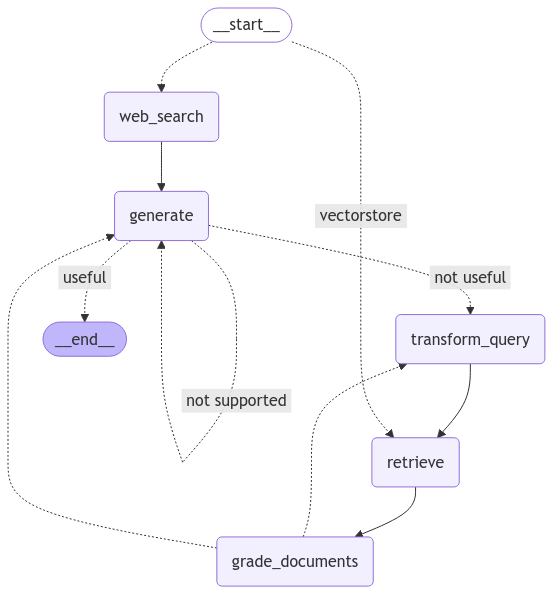

In [33]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_document)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    }
)

workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    }
)
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
from pprint import pprint

inputs = {"question": "谁管理的服务最多"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}': ")

    pprint("\n--\n")

pprint(value["generation"])  


# from pprint import pprint
# 
# # 向量匹配问题
# #inputs = {"question": "谁管理的服务数量最多？"}
# # 搜索问题
# inputs = {"question": "深圳最近的新闻"}
# 
# for output in app.stream(inputs):
#     for key, value in output.items():
#         # Node
#         pprint(f"Node '{key}':")
#         # Optional: print full state at each node
#         # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
#     pprint("\n---\n")
# 
# # Final generation
# pprint(value["generation"])

/Users/chenchen/Desktop/egg/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


---开始分流问题---
---问题分流到网络搜索---
---进行网络搜索---
"Node 'web_search': "
'\n--\n'
评估生成的回答是否基于知识库事实(是否产生了幻觉)
生成的回复不是基于知识库，继续重试...

"Node 'generate': "
'\n--\n'
评估生成的回答是否基于知识库事实(是否产生了幻觉)
生成的回复基于知识库，没有幻觉
问题没有得到解决

"Node 'generate': "
'\n--\n'
改写问题
LLM 改写优化后更好的问题: 哪个组织或个人提供的服务数量最多？
"Node 'transform_query': "
'\n--\n'


/var/folders/lz/tlk3ccq57bs_52pplnn0mk380000gn/T/ipykernel_69027/354751465.py:23: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(question)


"Node 'retrieve': "
'\n--\n'
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
访问检索到的相关知识库

所有的文档都不相关，重写问题
"Node 'grade_documents': "
'\n--\n'
改写问题
LLM 改写优化后更好的问题: 哪个组织或个人提供的服务数量最多？请提供相关的数据或排名信息。
"Node 'transform_query': "
'\n--\n'
"Node 'retrieve': "
'\n--\n'
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
访问检索到的相关知识库

所有的文档都不相关，重写问题
"Node 'grade_documents': "
'\n--\n'
改写问题
LLM 改写优化后更好的问题: 哪个组织或个人在服务提供方面的数量最多？请分享相关的统计数据或排名信息。
"Node 'transform_query': "
'\n--\n'
"Node 'retrieve': "
'\n--\n'
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
访问检索到的相关知识库

所有的文档都不相关，重写问题
"Node 'grade_documents': "
'\n--\n'
改写问题
LLM 改写优化后更好的问题: 哪个组织或个人在服务提供领域的数量最多？请提供相关的统计数据或排名信息，以便更好地理解这一现象。
"Node 'transform_query': "
'\n--\n'
"Node 'retrieve': "
'\n--\n'
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
文档和用户问题不相关
访问检索到的相关知识库

所有的文档都不相关，重写问题
"Node 'grade_documents': "
'\n--\n'
改写问题
LLM 改写优化后更好的问题: 在服务提供领域中，哪个组织或个人的数量最多？能否提供相关的统计数据或排名信息，以帮助我们更深入地理解这一现象？
"Node 'transform_query': "
'\n--\n'
"Node 'retrieve': "
'\n--\n'
文档和用户问题不相关
文档和用户问题不相关

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT